In [1]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import folium
import seaborn as sns
import pickle
import helper
import aux_functions as aux

destination="/Users/oysteinbruce/Documents/GitHub/SINTEF/fuel_model/data/raw_strict"
date = '2021-10-14'
eventsFile = f'{destination}/{date}_to_{date}_events_preprocessed.h5'
trackingFile = f'{destination}/{date}_to_{date}_tracking_events_preprocessed.h5'


    

In [3]:
destination="/Users/oysteinbruce/Documents/GitHub/SINTEF/fuel_model/data/raw_2809"
dates = [
        # '2021-09-28',
        # '2021-09-29',
        # '2021-10-11',
        # '2021-10-13',
        # '2021-10-14',
        # '2021-10-15',
        '2021-10-18',
        # '2021-10-19',
        # '2021-10-20',
        # '2021-10-21'
    ]

merged = pd.DataFrame()

for date in dates:
    filename = f'{destination}/{date}_to_{date}_merged.h5'
    merged_date = pd.read_hdf(filename)
    print(date, len(merged_date.TripLogId.unique()))
    merged = merged.append(merged_date)


# Removing pings while reversing
merged_forward = merged[merged.Forward > 0].copy()

# TODO: what does this mean?
# Quantity is stored per trip and not per trip type. Hence we reset quantity to 0 for all type 0 and 2 to 0
index = merged_forward.Type.isin([0, 2])
merged_forward.loc[index, 'Quantity'] = 0

# Check distribution of trips with only forward motion:
# Creating new triplogid that splits at subtrack
merged_forward['TypeTripLogId'] = merged_forward['TripLogId'] + '_' + merged_forward['subtrack'].astype('int').astype('str')


# Removing very long trips
print(len(merged_forward.TypeTripLogId.unique()))
merged_group = merged_forward.groupby('TypeTripLogId').size()
merged_group.hist(bins=100)

threshold = 500
capped = merged_group[merged_group < threshold] 
merged_forward = merged_forward[merged_forward.TypeTripLogId.isin(capped.index)].copy()
print(f'Number of unique subtracks: {len(merged_forward.TypeTripLogId.unique())}')
print(f'Number of data points: {len(merged_forward)}')



2021-10-18 11
8
Number of unique subtracks: 8
Number of data points: 465


In [63]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def sample_trips(merged,
                 trip_types = [1],
                 minlength = 30,
                 maxlength = 30,
                 TypeTripLogIds = None, 
                 Nsamples = 300,
                 idling_threshold = 1,
                 acceleration_threshold = 1,
                 altitude_threshold = 1,
                 Nplots = False,
                 half_unique = True,
                 fully_unique = False,
                 psedo_random = False):
    """
    Sample trip pieces from df.
    :param merged: Formatted dataframe with Ditio and Fuel data.
    :param trip_types: List of trip types to be considered. Trips are split between trip types
    :param minlength: Minimum length of samples i seconds
    :param maxlength: Maximum length of samples i seconds
    :param TripLogId: None for random sampling. Else a list of strings specifying the TypeTripLogId (TripLogId_Type) to compute stats and plot for.
    :param Nsamples: Numper of samples
    :idling_threshold: The threshold to distinguish between idling and non-idling in m/s. If zero, the machine is never idling (unless there are negative values) which is rare due to uncertainty. 1 m/s = 3.6 km/h
    :acceleration_threshold: The granularity in speed difference in m/s between bins to define acceleration/deceleration
    :altitude_threshold: The granularity in height difference in meters per bin used to define uphill/downhill movement
    :Nplots: Number of desired plots. Has to be smaller than Nsamples. Negative if no plots are desired. OBS will plot all samples from same triplogid
    :half_unique: avoids completely same trip (lag of 1 second is ok)
    :fully_unique: no overlap in our trips
    :return: dataframe with statistics from the samples
    """
    
    statdata = pd.DataFrame()

    # Removing pings while reversing
    merged = merged[merged.Forward > 0].copy()
    # Creating new triplogid that splits at subtrack
    merged['TypeTripLogId'] = merged['TripLogId'] + '_' + merged['subtrack'].astype('int').astype('str')
    
    # Sample with weights according to length of track 
    probabilities = merged.groupby('TypeTripLogId').size()
    probabilities = probabilities/probabilities.sum()

    if TypeTripLogIds == None:
        # List of Trips in df to sample from
        TypeTripLogIds_unique = merged.TypeTripLogId.unique()

        if psedo_random:
            np.random.seed(0)

        TypeTripLogIds = np.random.choice(TypeTripLogIds_unique, p=probabilities.values, size=Nsamples)

    Nplots = min(len(TypeTripLogIds), Nplots)
    plotTypeTripLogIds = np.random.choice(TypeTripLogIds, size=Nplots)
    
    # If the same id is in the Ids more than once, it will not be plotted. 
    already_plotted = []

    first_skip = True
    for TypeTripLogId in TypeTripLogIds:
        trip = merged[merged.TypeTripLogId == TypeTripLogId].copy()
        trip['TimeDiff'] = (trip.Timestamp - trip.Timestamp.min()).dt.total_seconds().values                  

        # Check if trip longer than minimum required sample length
        if trip.TimeDiff.max() >= minlength:
            # For a fixed minimum length, the sample subset cannot starter later than max(time) minus minimum length
            # max_feasible_start = np.max(np.min([trip.TimeDiff.max()-minlength, maxlength]), 0)    # TODO: delete
            max_feasible_start = np.max(trip.TimeDiff.max()-minlength, 0)
            start = int(np.random.uniform(low=0, high=max_feasible_start + 1))

            max_feasible_length = np.min([maxlength, trip.TimeDiff.max()-start])

            # length = int(np.random.uniform(low=minlength, high=max_feasible_length + 1))  # TODO: delete
            # Can't have a longer length than the max feasible length
            length = np.min([max_feasible_length, int(np.random.uniform(low=minlength, high=max_feasible_length + 1))])

            subset_index = (trip.TimeDiff >= start) & (trip.TimeDiff < start + length)
            
            subset = trip[subset_index].copy()
        
            subset['TimeDelta'] = subset.TimeDiff.diff().fillna(0)  # Timestep length
            subset['SpeedDiff'] = (subset['Speed'].diff()/subset['TimeDelta']).fillna(0)
            
            # Compute statistics
            statdata_row = pd.Series(dtype='object')
            statdata_row['TripLogId'] = subset.iloc[0].TripLogId
            statdata_row['TypeTripLogId'] = subset.iloc[0].TypeTripLogId
            statdata_row['DistanceFullyRoute'] = trip['DistanceCumsum'].max() - trip['DistanceCumsum'].min()
            statdata_row['ControlStartTime'] = start
            statdata_row['ControlStartTimeClock'] = str(subset.index[0])
            statdata_row['Type'] = subset.Type.mode().values[0]  # Assign the type that is most frequent
            statdata_row['StartTime'] = subset.iloc[0].Timestamp
            statdata_row['Month'] = subset.iloc[0].Timestamp.month
            statdata_row['LengthTime'] = length
            statdata_row['LengthDistance'] = subset['DistanceCumsum'].max() - subset['DistanceCumsum'].min()
            # statdata_row['SpeedMean'] = subset['Speed'].mean() TODO: delete? - more accurate with distance/ time?
            statdata_row['SpeedMean'] = statdata_row['LengthDistance']/statdata_row['LengthTime']
            statdata_row['SpeedVariance'] = subset['Speed'].var()
            statdata_row['Quantity'] = subset.iloc[0].Quantity
            statdata_row['id_uniq_stat'] = statdata_row['TypeTripLogId'] + '_' + str(start)
            
            # If we want partly unique samples, or fully unique samples
            if half_unique or fully_unique:
                if first_skip:
                    first_skip = False
                else:
                    same_trip_id = statdata[statdata['TypeTripLogId'] == TypeTripLogId]
                    overlap = np.sum((same_trip_id.ControlStartTime > start - 30) & (same_trip_id.ControlStartTime < start + 30)) > 0
                    
                    if (len(same_trip_id) > 0):
                        # if we have the exact same trip
                        if half_unique and (np.sum(same_trip_id.ControlStartTime == start) > 0):
                            continue
                        # if we have some overlap in our trip
                        elif fully_unique and overlap:
                            continue


            # Integral over increases in velocity (=acceleration)
            index_positive = subset['SpeedDiff'] > acceleration_threshold
            # Sum of positive acceleration
            statdata_row['SpeedDiffPositiveSum'] = (subset.loc[index_positive,'SpeedDiff'] * 
                                                    subset['TimeDelta'].loc[index_positive]).sum()  
            # Fuel used while accelerating
            statdata_row['AccFuel'] = (subset.loc[index_positive,'FuelCumsumDiff'] * 
                                       subset['TimeDelta'].loc[index_positive]).sum()
            # Time while accelerating
            statdata_row['AccTime'] = (subset['TimeDelta'].loc[index_positive]).sum()
            
            # Integral over decreases in velocity (=decceleration)
            index_negative = subset['SpeedDiff'] < acceleration_threshold
             # Sum of negative acceleration
            statdata_row['SpeedDiffNegativeSum'] = (subset.loc[index_negative,'SpeedDiff'] *
                                                    subset['TimeDelta'].loc[index_negative]).sum() 
            
            # Sum of positive/negative altitude differences
            subset['AltitudeDiff'] = subset['Altitude'].diff().fillna(0)
            index_uphill = subset['AltitudeDiff'] > altitude_threshold
            index_downhill = subset['AltitudeDiff'] < -altitude_threshold
            statdata_row['AltitudeLoss'] = subset.loc[index_downhill, 'AltitudeDiff'].sum()  
            statdata_row['AltitudeGain'] = subset.loc[index_uphill, 'AltitudeDiff'].sum()
            
            altitudeLossPart = [0]
            altitudeGainPart = [0] 
            for part_i in range(int(length/2)):
                part_altitude_change = subset['AltitudeDiff'][part_i : (15 + part_i)]
                altitudeLossPart.append(part_altitude_change[part_altitude_change < 0].sum())
                altitudeGainPart.append(part_altitude_change[part_altitude_change > 0].sum())

            statdata_row['AltitudeLossPart'] = min(altitudeLossPart)
            statdata_row['AltitudeGainPart'] = max(altitudeGainPart)


            statdata_row['AltitudeChange'] = statdata_row['AltitudeGain'] + abs(statdata_row['AltitudeLoss'])
            
            statdata_row['AltitudeDeltaEndStart'] = subset['Altitude'].iloc[-1] - subset['Altitude'].iloc[0]
            statdata_row['AltitudeDeltaMaxMin'] = subset['Altitude'].max() - subset['Altitude'].min()

            # Average inclinations
            average_downInclination_part = [0]
            average_upInclination_part = [0]

            for part_i in range(int(length/2)):
                part_incline = (subset['AltitudeDiff']/subset['DistanceCumsumDiff'])[part_i : (15 + part_i)]
                average_downInclination_part.append(part_incline[part_incline < 0].mean())
                average_upInclination_part.append(part_incline[part_incline > 0].mean())

            statdata_row['DownInclination'] = 0
            statdata_row['DownInclinationPart'] = 0 
            if np.sum(index_downhill) > 0:
                statdata_row['DownInclination'] = statdata_row['AltitudeLoss']/subset.loc[index_downhill, 'DistanceCumsumDiff'].sum()
                statdata_row['DownInclinationPart'] = min(average_downInclination_part)

            statdata_row['UpInclination'] = 0
            statdata_row['UpInclinationPart'] = 0 
            if np.sum(index_uphill) > 0:
                statdata_row['UpInclination'] = statdata_row['AltitudeGain']/subset.loc[index_uphill, 'DistanceCumsumDiff'].sum()
                statdata_row['UpInclinationPart'] = max(average_upInclination_part)

 #           print(statdata_row['AltitudeLoss'], subset.loc[index_downhill, 'DistanceCumsumDiff'].sum(), 
 #                 statdata_row['AltitudeGain'], subset.loc[index_uphill, 'DistanceCumsumDiff'].sum(),
 #                 statdata_row['DownInclination'], statdata_row['UpInclination'])
            
            # Time with idling and fuel during idling
            index_idling = subset['Speed'] < idling_threshold
            statdata_row['IdlingTime'] = subset.loc[index_idling, 'TimeDelta'].sum()
            statdata_row['IdlingFuel'] = (subset.loc[index_idling, 'TimeDelta']*subset.loc[index_idling, 'FuelCumsumDiff']).sum()
            
            # Sum of changes in direction
            # Data has already been filtered for large changes in angle, so we assume only smallest change is relevant
#            TODO: double check this
            subset['DiffCourse'] = subset.Course.diff().abs()
            subset['DiffCourse360'] = (360 - subset['DiffCourse'])
            subset['DeltaCourse'] = subset[['DiffCourse', 'DiffCourse360']].min(axis=1)

            # statdata_row['SumRotation'] = 1 #subset[['DeltaCourse', 'DeltaCourse180']].min(axis=1).sum()
            statdata_row['SumRotation'] = subset['DiffCourse'][subset['DiffCourse'] < 200].sum()
            statdata_row['Sum_RotationXAltitudeDiffPos'] = (subset['DiffCourse'][(subset['DiffCourse'] < 200) & (index_uphill)] \
                * subset['AltitudeDiff'][(subset['DiffCourse'] < 200) & (index_uphill)]).sum()
            statdata_row['Sum_RotationXAltitudeDiffNeg'] = (subset['DiffCourse'][(subset['DiffCourse'] < 200) & (index_downhill)] \
                * subset['AltitudeDiff'][(subset['DiffCourse'] < 200) & (index_downhill)]).sum()

            # Fuel
            statdata_row['Fuel'] = subset['FuelCumsum'].max() - subset['FuelCumsum'].min()
            
            if (statdata_row.Quantity > 0) & (statdata_row['LengthDistance'] > 0):
                statdata_row['FuelPerTonPerMeter'] = statdata_row['Fuel']/statdata_row['Quantity']/statdata_row['LengthDistance'] 
        
            statdata = statdata.append(statdata_row, ignore_index=True)
            
            
            if TypeTripLogId in plotTypeTripLogIds and not TypeTripLogId in already_plotted:
                already_plotted.append(TypeTripLogId)
                
                N=6
                fig, axs = plt.subplots(1, N, figsize=(5*N, 6))
                fig.suptitle(f'{TypeTripLogId}, length trip [s]: {int(trip.TimeDiff.max())}, start [s]: {int(start)}, length [s]: {int(length)}, rotation: {statdata_row.SumRotation}', fontsize=16)

                i = 0
                im = axs[i].scatter(trip.x, trip.y, marker='o', alpha=0.5, c=trip.TimeDiff)
                plt.colorbar(im, ax=axs[i])
                axs[i].scatter(subset.x, subset.y, marker='x', color='black')
                axs[i].ticklabel_format(style='plain')
            
                i = 1
                xy_cols = ['TimeDiff', 'DistanceCumsum']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].scatter(x, y, marker='o', alpha=0.5, label='All')
                axs[i].set_xlabel(xy_cols[0])
                axs[i].set_ylabel(xy_cols[1])
                
                x = subset.loc[index_idling, xy_cols[0]]
                y = subset.loc[index_idling, xy_cols[1]]
                axs[i].scatter(x, y, alpha=0.5, label='Idling')
                axs[i].legend()

                
                i = 2
                xy_cols = ['TimeDiff', 'Speed']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].plot(x, y, alpha=1)
                axs[i].set_xlabel(xy_cols[0])
                axs[i].set_ylabel(xy_cols[1])
                axs[i].axhline(idling_threshold)

                x = subset.loc[index_positive, xy_cols[0]]
                y = (subset.loc[index_positive,'SpeedDiff'] * subset['TimeDelta'].loc[index_positive]).cumsum() + subset.iloc[0][xy_cols[1]]
                axs[i].scatter(x, y, alpha=0.5, label='SpeedDiffPositiveCumSum')
                x = subset.loc[index_negative, xy_cols[0]]
                y = (subset.loc[index_negative,'SpeedDiff'] * subset['TimeDelta'].loc[index_negative]).cumsum() + subset.iloc[0][xy_cols[1]]
                axs[i].scatter(x, y, alpha=0.5, label='SpeedDiffNegativeCumSum')

                x = subset.loc[index_idling, xy_cols[0]]
                y = subset.loc[index_idling,'Speed']
                axs[i].scatter(x, y, alpha=0.5, label='Idling')

                
                axs[i].legend()

                i = 3
                xy_cols = ['TimeDiff', 'Altitude']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].plot(x, y, alpha=1)
                axs[i].set_xlabel(xy_cols[0])
                axs[i].set_ylabel(xy_cols[1])

                x = subset.loc[index_uphill, xy_cols[0]]
                y = subset.loc[index_uphill, 'AltitudeDiff'].cumsum() + subset.iloc[0][xy_cols[1]]
                axs[i].scatter(x, y, alpha=0.5, label='AltitudeGain')
                x = subset.loc[index_downhill, xy_cols[0]]
                y = subset.loc[index_downhill, 'AltitudeDiff'].cumsum() + subset.iloc[0][xy_cols[1]]
                axs[i].scatter(x, y, alpha=0.5, label='AltitideLoss')
                axs[i].legend()

                i = 4
                xy_cols = ['TimeDiff', 'FuelCumsum']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].plot(x, y, alpha=1)
                axs[i].set_xlabel(xy_cols[0])
                axs[i].set_ylabel(xy_cols[1])
 
                x = subset.loc[index_positive, xy_cols[0]]
                y = subset.loc[index_positive, xy_cols[1]]
                axs[i].scatter(x, y, alpha=0.5, label='SpeedDiffPositive')

#                x = subset.loc[index_idling, xy_cols[0]]
#                y = (subset.loc[index_idling, 'TimeDelta']*subset.loc[index_idling, 'FuelCumsumDiff']).cumsum() + subset.iloc[0][xy_cols[1]]
#                axs[i].scatter(x, y, alpha=0.5, label='Fuel idling')
                
                x = subset.loc[index_positive, xy_cols[0]]
                y = (subset.loc[index_positive, 'FuelCumsumDiff'] * subset.loc[index_positive, 'TimeDelta']).cumsum() + subset.iloc[0][xy_cols[1]]

                axs[i].scatter(x, y, alpha=0.5, label='Fuel accelerating')
                axs[i].legend()

                i = 5
                xy_cols = ['TimeDiff', 'Course']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].scatter(x, y, marker='o', alpha=0.5, label='Course')
                axs[i].set_xlabel(xy_cols[0])
                axs[i].set_ylabel(xy_cols[1])

                xy_cols = ['TimeDiff', 'DiffCourse']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].scatter(x, y, marker='o', alpha=0.5, label='Diff')

                xy_cols = ['TimeDiff', 'DiffCourse360']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].scatter(x, y, marker='x', alpha=0.5, label='Diff360')

                xy_cols = ['TimeDiff', 'DeltaCourse']
                x = subset[xy_cols[0]]
                y = subset[xy_cols[1]]
                axs[i].scatter(x, y, marker='x', alpha=0.5, label='Delta')

                axs[i].legend()
                

                plt.show()
                plt.close()
 
    return statdata


In [64]:
# Run the sampling and select some trips to plot

TripTypes = [0,1,2]
TypeTripLogIds = None
#['6168400dfd6b890000082df2_1']
statdata = sample_trips(merged_forward, trip_types=TripTypes,
                 minlength = 30,
                 maxlength = 30,
                 Nsamples = 500,
                 TypeTripLogIds = TypeTripLogIds,
                 idling_threshold = 1,
                 acceleration_threshold = 0.01,
                 altitude_threshold = .01,
                 Nplots = 0,
                 half_unique = True, 
                 fully_unique = False)

In [2]:
statdata, _ = helper.get_df_of_statistics(['2021-10-18'], sub_name = 'fully_unique')

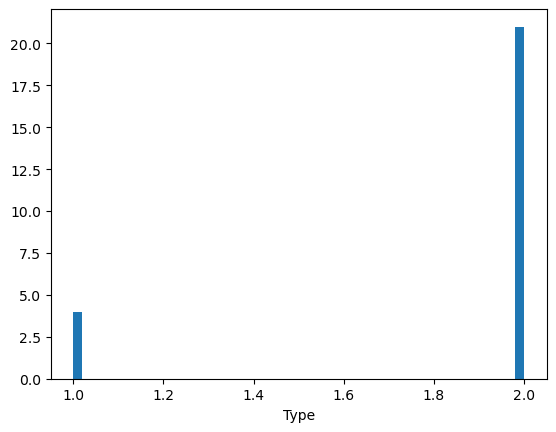

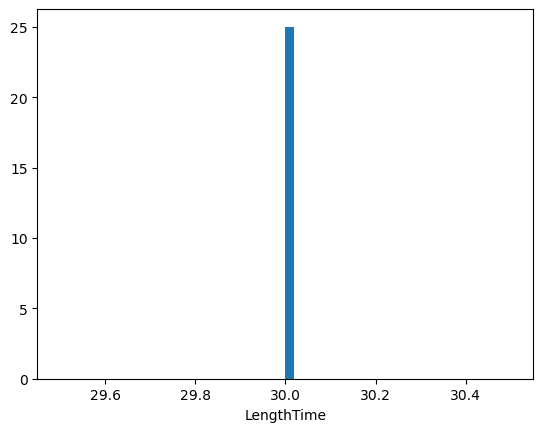

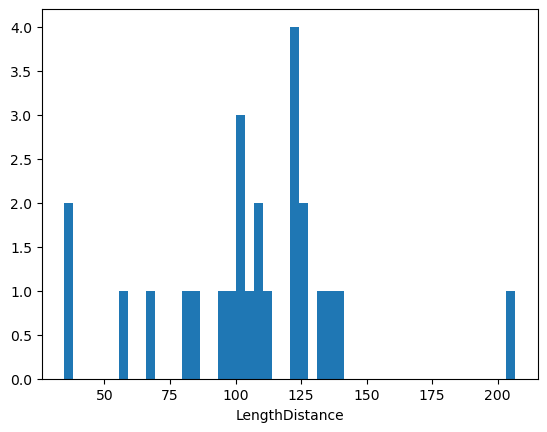

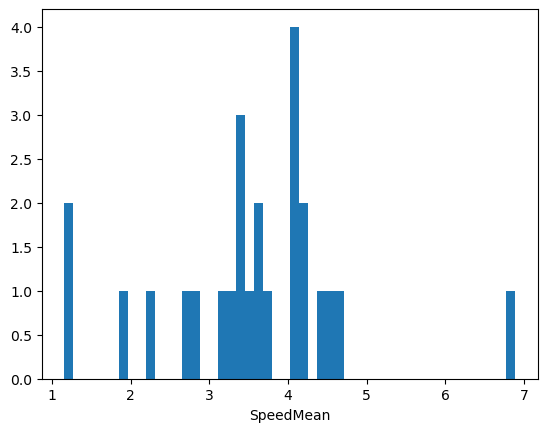

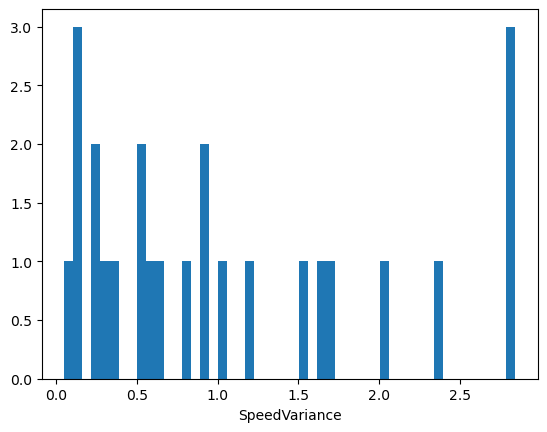

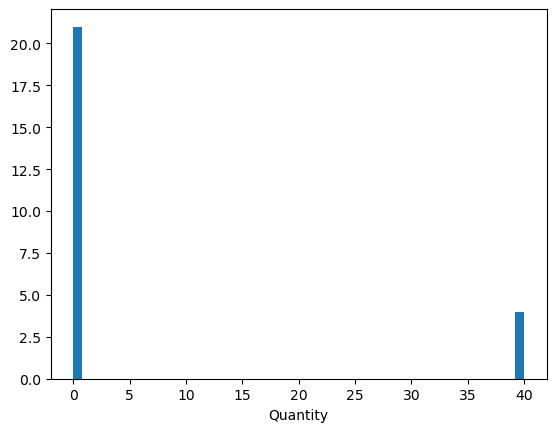

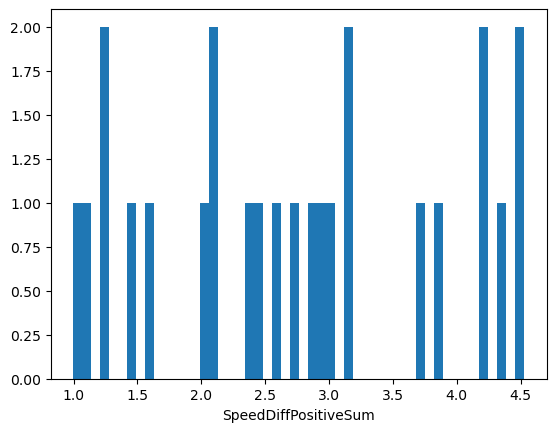

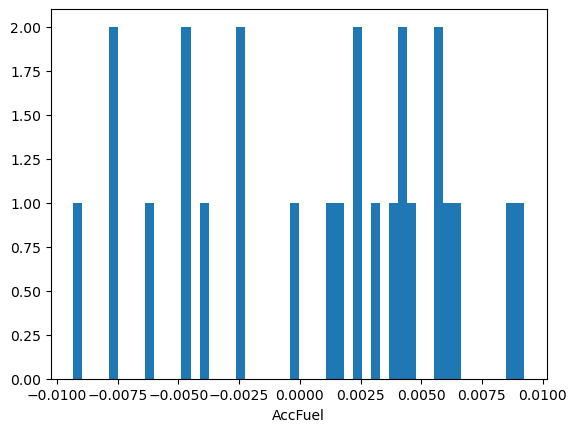

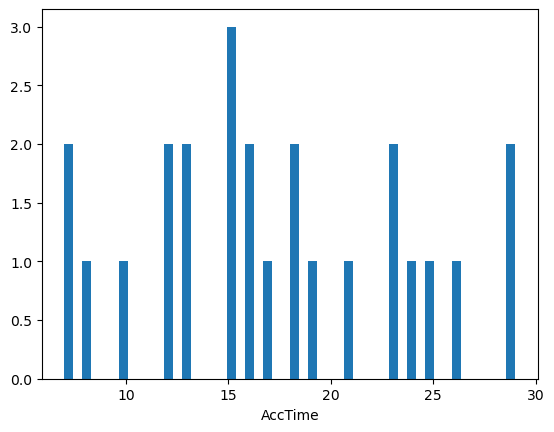

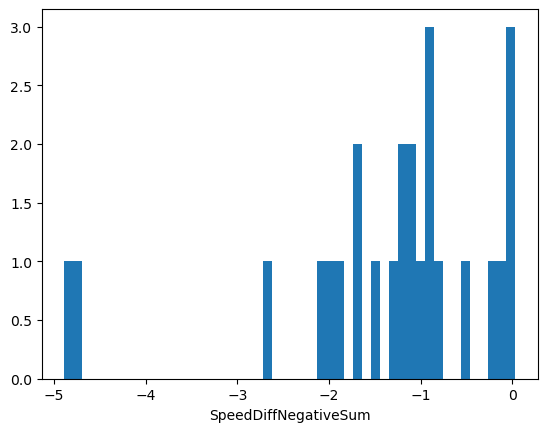

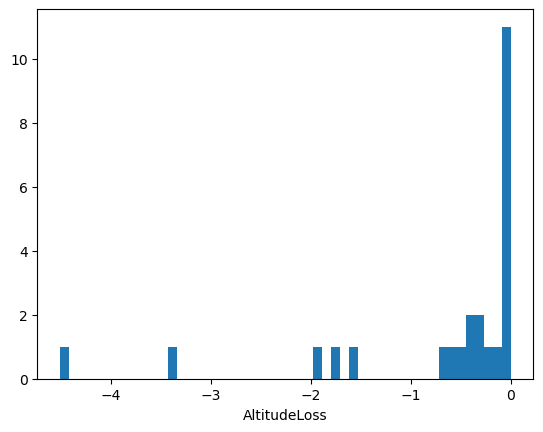

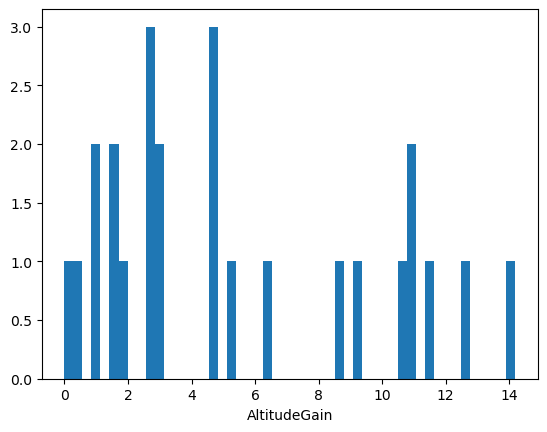

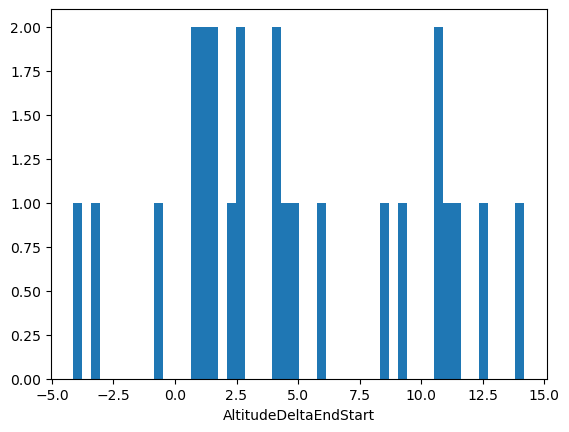

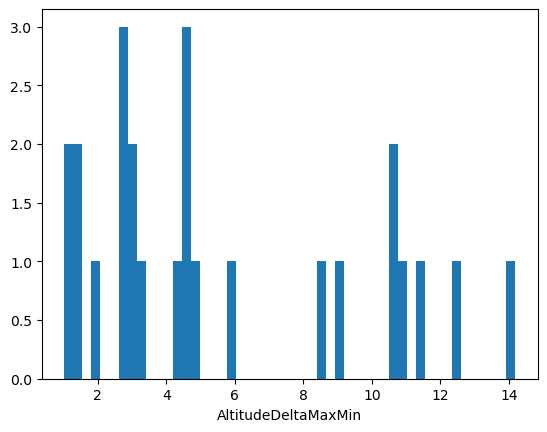

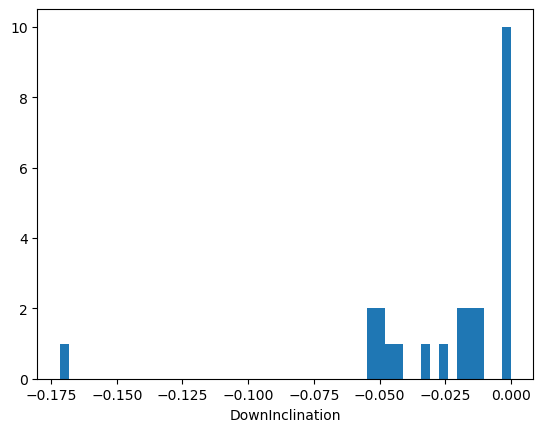

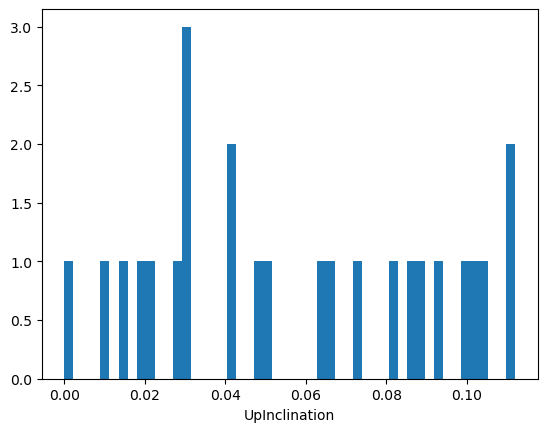

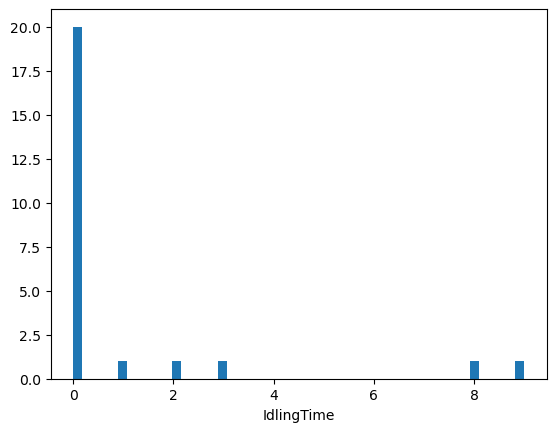

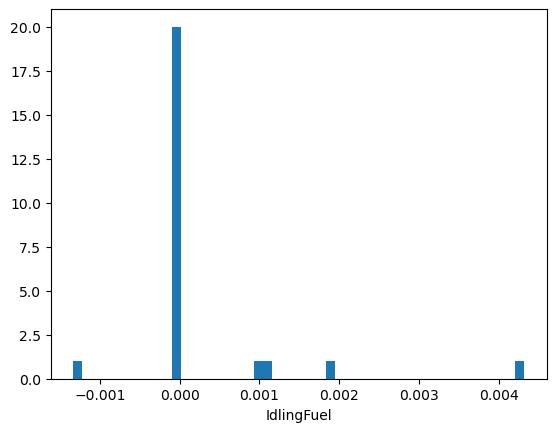

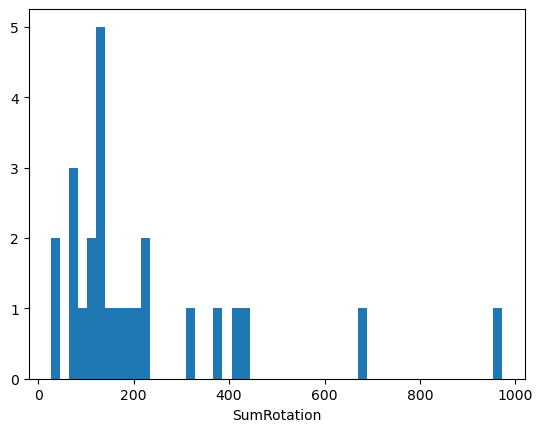

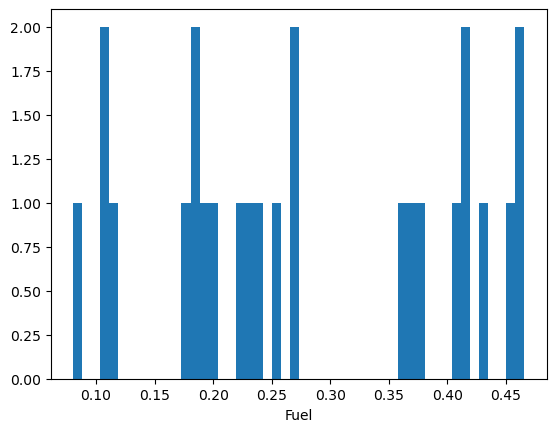

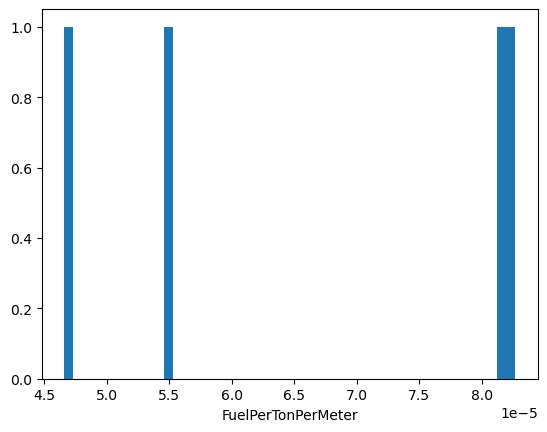

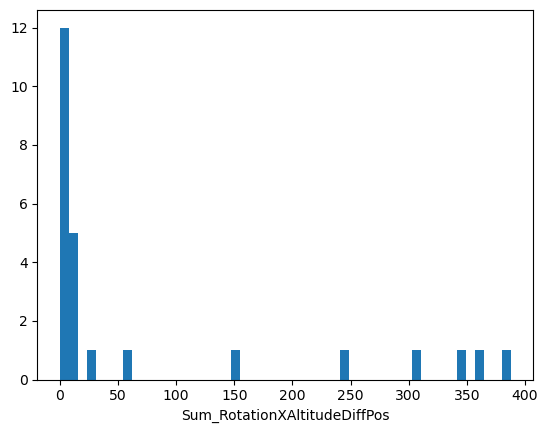

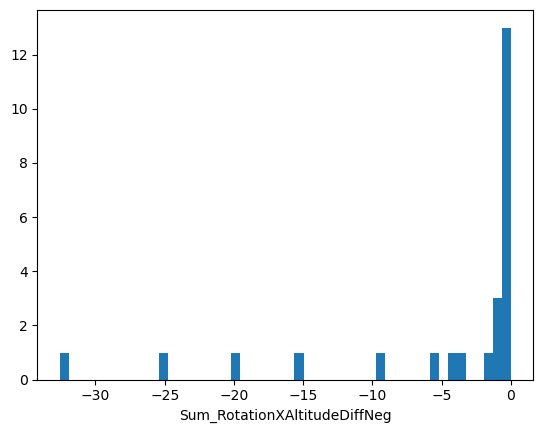

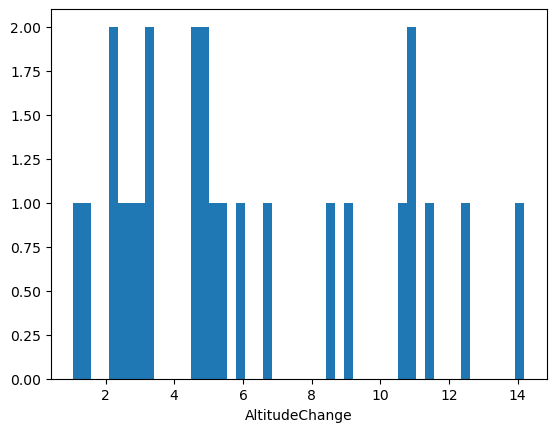

In [75]:
statdata.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = ['Type', 'LengthTime',
       'LengthDistance', 'SpeedMean', 'SpeedVariance', 'Quantity',
       'SpeedDiffPositiveSum', 'AccFuel', 'AccTime', 'SpeedDiffNegativeSum',
       'AltitudeLoss', 'AltitudeGain', 'AltitudeDeltaEndStart',
       'AltitudeDeltaMaxMin', 'DownInclination', 'UpInclination',
       'IdlingTime', 'IdlingFuel', 'SumRotation', 'Fuel',
       'FuelPerTonPerMeter', 'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg', 'AltitudeChange']
       
for col in cols:
    plt.hist(statdata[col], bins=50)
    plt.xlabel(col)
    plt.show()

In [23]:
statdata, _ = helper.get_df_of_statistics(['2021-10-18'], sub_name = 'fully_unique')
# folder = helper.PATH_QUICK_RUN + 'models_and_results17' #FINAL
# filename = folder + '/models/without_2021-10-15' + '.pkl' #FINAL
folder = helper.PATH_QUICK_RUN + 'models_and_results15'
filename = folder + '/models/without_2021-10-18' + '.pkl'
model_xgb_loaded = pickle.load(open(filename,  'rb'))


X_feat_all = ['LengthDistance', #'LengthTime',
        'Quantity', 'Type',  
        'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', 'AltitudeChange',
        'AltitudeLossPart', 'AltitudeGainPart',
        'AltitudeDeltaMaxMin',
        'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg',
        'DownInclination', 'UpInclination',
        'DownInclinationPart', 'UpInclinationPart',
        #'Fuel',
         'AccTime',
        'SpeedMean', # 'SpeedVariance', 
         #'SpeedDiffPositiveSum', 'SpeedDiffNegativeSum', 
         #'IdlingTime', 'SumRotation',
         'SumRotation', 'TypeTripLogId', 'DistanceFullyRoute', 'ControlStartTime', 'ControlStartTimeClock' 
        ]

        
infile = open(folder + '/features.txt', 'r')
X_feat = []
for line in infile:
        X_feat.append(line.strip())
infile.close()


# X_feat = ['LengthDistance', #'LengthTime',
#         'Quantity', #'Type',  
#         'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', 'AltitudeChange',
#         'AltitudeDeltaMaxMin',
#         'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg',
#         #'DownInclination', 'UpInclination',
#         #'Fuel',
#          #'AccTime',
#         'SpeedMean', # 'SpeedVariance', 
#          #'SpeedDiffPositiveSum', 'SpeedDiffNegativeSum', 
#          #'IdlingTime', 'SumRotation',
#          'SumRotation',
#         ]

y_feat = ['Fuel']

y_val = statdata[y_feat]


index_1 = y_val.sort_values('Fuel').index

X_val_fact_sorted = statdata[X_feat_all].iloc[index_1]

X_val_sorted = X_val_fact_sorted[X_feat]
y_val_sorted = y_val.iloc[index_1].values.flatten()

In [24]:
from sklearn.metrics import mean_squared_error

y_pred_xgb_val = model_xgb_loaded.predict(X_val_sorted)
mse_xgb_val = mean_squared_error(y_pred_xgb_val, y_val_sorted)

print(f'Validation error: {mse_xgb_val}')

Validation error: 0.00807419660755804


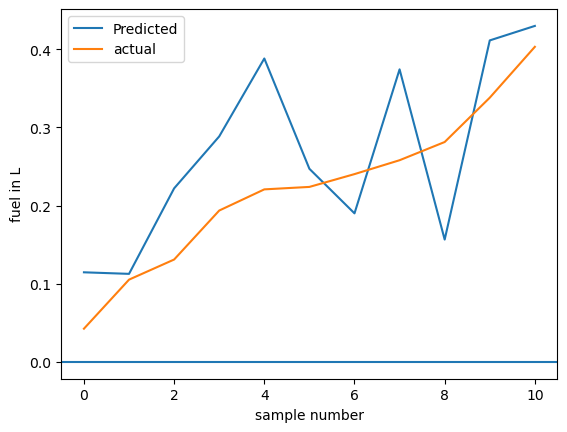

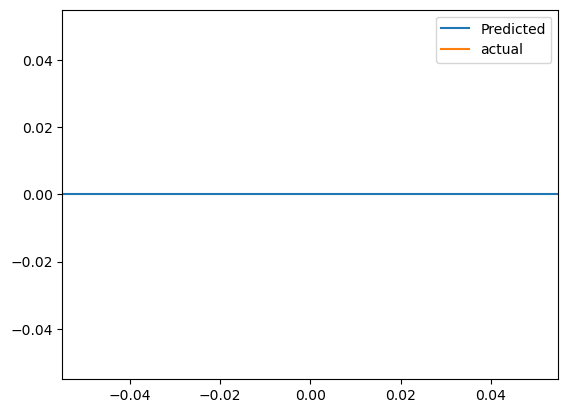

In [25]:

plt.plot(y_pred_xgb_val, linestyle=None, label = "Predicted")
plt.plot(y_val_sorted, linestyle=None, label = "actual")
plt.xlabel('sample number')
plt.ylabel('fuel in L')
plt.legend()
plt.axhline(0)
plt.show()
start_ = 40
plt.plot(y_pred_xgb_val[start_: start_ + 10], linestyle=None, label = "Predicted")
plt.plot(y_val_sorted[start_: start_ + 10], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

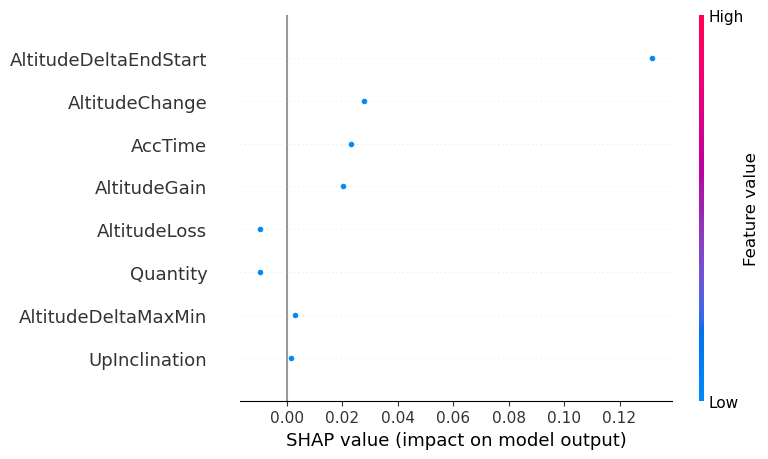

LengthDistance : 60.430106737530096
Quantity : 0.0
Type : 1.0
AltitudeGain : 10.503218744195578
AltitudeLoss : 0.0
AltitudeDeltaEndStart : 10.503218744195578
AltitudeChange : 10.503218744195578
AltitudeLossPart : 0.0
AltitudeGainPart : 6.70403048586104
AltitudeDeltaMaxMin : 10.503218744195578
Sum_RotationXAltitudeDiffPos : 42.71754635107073
Sum_RotationXAltitudeDiffNeg : 0.0
DownInclination : 0.0
UpInclination : 0.1738077145852956
DownInclinationPart : 0.0
UpInclinationPart : 0.20192846757670246
AccTime : 14.0
SpeedMean : 2.0143368912510033
SumRotation : 101.3485947233899
TypeTripLogId : 61714d99aef0ba00009eef76__0_0
DistanceFullyRoute : 73.44402094643493
ControlStartTime : 1
ControlStartTimeClock : 2021-10-21 11:25:05+00:00


PREDICTION:           0.4599
Actual value:         0.6247

TypeTripLogId: 61714d99aef0ba00009eef76__0_0
Control, distance: 60.430106737530096
Control, distance fully: 73.44402094643493
Control, startTime: 1
Control, startTimeClock: 2021-10-21 11:25:05+00:00


In [18]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
row_to_show = 22
data_for_prediction = X_val_sorted.iloc[row_to_show].values.reshape(1, -1)
explainer = shap.TreeExplainer(model_xgb_loaded)

data_for_prediction


# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.summary_plot(shap_values, data_for_prediction, feature_names = X_feat)

for a, b in zip(X_val_fact_sorted.iloc[row_to_show], X_feat_all):
    print(f'{b} : {a}')

print(f'\n\nPREDICTION: {model_xgb_loaded.predict(data_for_prediction)[0] : 16.4f}')
print(f'Actual value: {y_val_sorted[row_to_show] : 14.4f}')
print(f"\nTypeTripLogId: {X_val_fact_sorted.iloc[row_to_show]['TypeTripLogId']}")
print(f"Control, distance: {X_val_fact_sorted.iloc[row_to_show]['LengthDistance']}")
print(f"Control, distance fully: {X_val_fact_sorted.iloc[row_to_show]['DistanceFullyRoute']}")
print(f"Control, startTime: {X_val_fact_sorted.iloc[row_to_show]['ControlStartTime']}")
print(f"Control, startTimeClock: {X_val_fact_sorted.iloc[row_to_show]['ControlStartTimeClock']}")





In [31]:
X_feat

['LengthDistance',
 'Quantity',
 'AltitudeGain',
 'AltitudeLoss',
 'AltitudeDeltaEndStart',
 'AltitudeChange',
 'AltitudeDeltaMaxMin',
 'Sum_RotationXAltitudeDiffPos',
 'Sum_RotationXAltitudeDiffNeg',
 'SpeedMean',
 'SumRotation']

In [48]:
# # ['LengthDistance', 'Quantity', 'AltitudeGain', 'AltitudeLoss', 'AltitudeDeltaEndStart', 
# # 'AltitudeChange', 'Sum_RotationXAltitudeDiffPos', 'Sum_RotationXAltitudeDiffNeg', 'SpeedMean', 'SumRotation']

data_for_prediction1 = data_for_prediction.copy()
# preds_list = []
# for i in range(1, 24):

#     # data_for_prediction1[0][2] = data_for_prediction[0][2] + (-10 + i)
#     # data_for_prediction1[0][2] = data_for_prediction[0][2] + (-i/12)
#     data_for_prediction1[0][3] = data_for_prediction[0][3] + (i/12)
#     data_for_prediction1[0][4] = data_for_prediction[0][4] + (i/12)
    
#     preds = model_xgb_loaded.predict(data_for_prediction1)[0] 

#     print(data_for_prediction1[0][3], data_for_prediction1[0][4], preds)

data_for_prediction1[0][1] = 40
print(data_for_prediction1[0][1])
print(data_for_prediction[0][1])

print(f'\n\nPREDICTION: {model_xgb_loaded.predict(data_for_prediction)[0] : 16.4f}')
print(f'\n\nPREDICTION: {model_xgb_loaded.predict(data_for_prediction1)[0] : 16.4f}')
print(f'Actual value: {y_val_sorted[row_to_show] : 14.4f}')




40.0
0.0


PREDICTION:           0.5297


PREDICTION:           0.5265
Actual value:         0.2185


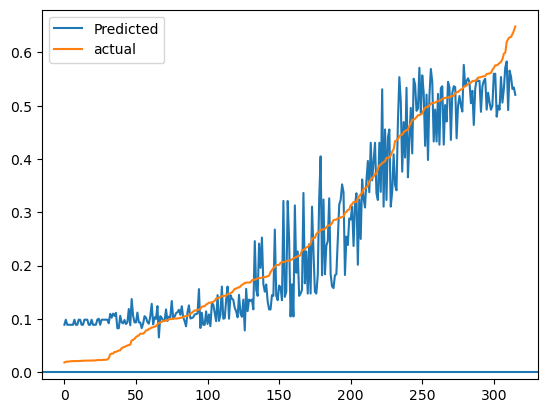

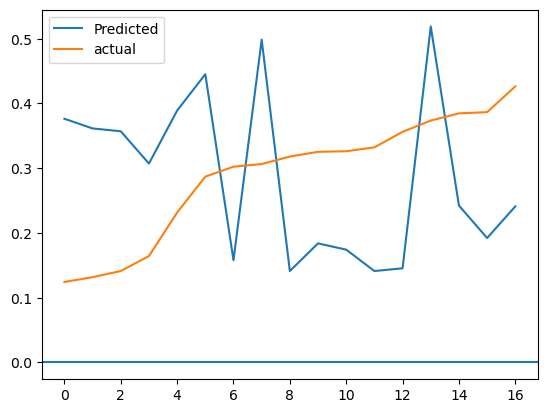

In [11]:
quantile = 0.95
quantile_secure = np.abs(y_pred_xgb_val - y_val_sorted) < np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile)
quantile_fail = np.abs(y_pred_xgb_val - y_val_sorted) > np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile)


plt.plot(y_pred_xgb_val[quantile_secure], linestyle=None, label = "Predicted")
plt.plot(y_val_sorted[quantile_secure], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

plt.plot(y_pred_xgb_val[quantile_fail], linestyle=None, label = "Predicted")
plt.plot(y_val_sorted[quantile_fail], linestyle=None, label = "actual")
plt.legend()
plt.axhline(0)
plt.show()

In [66]:
# IS XGBoost better more correct at pretty sure things, and random forest better on difficult parts???
quantile = 0.5
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile) : .4f}')

quantile = 0.75
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile) : .4f}')

quantile = 0.90
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile) : .4f}')

quantile = 0.99
print(f'{quantile}-Quantile, XGboost:  {np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile) : .4f}')

print(f'MSE, XGboost: {mse_xgb_val}')

0.5-Quantile, XGboost:   0.0498
0.75-Quantile, XGboost:   0.0780
0.9-Quantile, XGboost:   0.1169
0.99-Quantile, XGboost:   0.3028
MSE, XGboost: 0.006992203491104673


In [44]:
# Look at failures
quantile = 0.90
quantile_fail = np.abs(y_pred_xgb_val - y_val_sorted) > np.quantile(np.abs(y_pred_xgb_val - y_val_sorted), quantile)

data_for_prediction = X_val_sorted.iloc[quantile_fail].values


true_labels = y_val_sorted[quantile_fail]
print('LengthDistance, AltitudeDeltaEndStart')
for j in range(np.sum(quantile_fail)):
    print('\n--------------------------------')
    print(f'Case: {j}: ')
    for i, (a, b) in enumerate(zip(data_for_prediction[j], X_feat)):
        if (b in 'LengthDistance'):
            print(f'({a:.3f}, ', end = "")
        if (b in 'AltitudeDeltaEndStart'):
            print(f'{a:.3f})')

    print(f'\nPREDICTION: {model_xgb_loaded.predict(data_for_prediction)[j] : 16.4f}')
    print(f'Actual value: {true_labels[j] : 14.4f}')


LengthDistance, AltitudeDeltaEndStart

--------------------------------
Case: 0: 
(98.921, -5.221)

PREDICTION:           0.1532
Actual value:         0.0251

--------------------------------
Case: 1: 
(103.027, -5.278)

PREDICTION:           0.1532
Actual value:         0.0299

--------------------------------
Case: 2: 
(99.458, 1.671)

PREDICTION:           0.2656
Actual value:         0.1399

--------------------------------
Case: 3: 
(65.527, 2.198)

PREDICTION:           0.3389
Actual value:         0.1409

--------------------------------
Case: 4: 
(88.816, 2.419)

PREDICTION:           0.3872
Actual value:         0.1744

--------------------------------
Case: 5: 
(91.962, 2.607)

PREDICTION:           0.4231
Actual value:         0.1886

--------------------------------
Case: 6: 
(122.853, 3.172)

PREDICTION:           0.3364
Actual value:         0.1990

--------------------------------
Case: 7: 
(104.642, 3.581)

PREDICTION:           0.4277
Actual value:         0.2558

----